In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import hashlib
import scipy.stats
import pickle, time, os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.25)

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # Whether to use GPU or not
tf.logging.set_verbosity(tf.logging.ERROR)
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth=True

import entropy, loaddata, mc_entropy
import loaddata



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
def loadresults(sess, data, basedir, sfx, verbose=0, rerun=False, store_batch=False):
    Xbatch, saver = None, None
    vals = {}
    
    print("Doing", basedir, sfx)
        
    for fname in os.listdir(basedir):
        if not fname.endswith(sfx):
            continue

        fullfname = os.path.join(basedir, fname, 'data')
        if verbose > 0:
            print(fullfname)
        with open(fullfname, 'rb') as f:
            try:    
                cfg, saved_data = pickle.load(f)
            except: 
                print("Error loading pickle file") ; continue


        runtype = cfg['runtype']
        if cfg['runtype'] != data['runtype']:
            raise Exception('Wrong dataset')

        sqmode = 'sq' if cfg['squaredIB'] else 'reg'
        beta   = saved_data[0]['beta']
        method = saved_data[0]['mode'] # mode indicates 'ce' vs 'nlIB' vs 'VIB'
        backtrack = cfg['early_stopping_patience']
        
        for trntstmode in ['trn','tst']:
            val_dict = {'beta': beta}
            # sess, saver = None, None

            #for lrow in saved_data[-n_average_epoch-backtrack:-backtrack]:
            if len(saved_data) < backtrack:
                continue
                
            lrow = saved_data[-backtrack]
                
            var   = lrow['noisevar']
            l     = lrow[trntstmode]
            epoch = lrow['epoch']

            epoch_fname = '%s/%s/tf_model-%d' % (basedir, fname, epoch)
            epoch_fname_full = epoch_fname+'.data-00000-of-00001'

            if not os.path.exists(epoch_fname_full):
                print("ERROR: Cant find %s" % epoch_fname_full)
                print(backtrack, epoch, len(saved_data), saved_data[-1]['epoch'])
                continue

            h = hashlib.md5(open(epoch_fname_full,'rb').read()).hexdigest() + '-' + trntstmode
            cache_dir = '.mc_entropy_cache'
            if not os.path.exists(cache_dir):
                os.makedirs(cache_dir)

            cachefile_exists =  os.path.exists(cache_dir + '/'+h)
            if not rerun and cachefile_exists: # cache calculations
                with open(cache_dir + '/'+h, 'rb') as f:
                    l = pickle.load(f)
            else:
                if cachefile_exists:
                    os.remove(cache_dir + '/'+h)

                if saver is None:
                    saver = tf.train.import_meta_graph(tf.train.latest_checkpoint('%s/%s' % (basedir, fname))+'.meta')

                saver.restore(sess, epoch_fname)

                if Xbatch is None:
                    permutation  = np.random.permutation(len(data[trntstmode+'_X']))
                    Xbatch = data[trntstmode+'_X'][permutation[:2000]]
                    Ybatch = np.argmax(data[trntstmode+'_Y'][permutation[:2000]],axis=1)

                mx          = sess.run( 'noisy_ib_layer/RawInput:0' , feed_dict={'X:0':Xbatch})
                
                n, d        = mx.shape
                mcH         = mc_entropy.get_mc_entropy(mx, var)
                hCond       = entropy.gaussian_entropy_np(d, var)
                l['beta']   = beta
                l['Ixt_mc'] = mcH - hCond
                l['noisevar'] = var
                
                if store_batch:
                    l['hidden_acts'] = sess.run( 'noisy_ib_layer/RawInput:0' , feed_dict={'X:0':data[trntstmode+'_X']})
                    l['pred_y']      = data[trntstmode+'_Y']
                    if data['err'] != 'mse':
                        l['pred_y'] = np.argmax(data[trntstmode+'_Y'],axis=1)

                with open(cache_dir + '/'+h, 'wb') as f:
                    pickle.dump(l, f)

            val_dict = l
                #for k in ['Ixt','Ixt_lb','Iyt','Ixt_mc','ce']:
                #    if k not in val_dict:
                #        val_dict[k]=0.
                #    val_dict[k] += l[k]/np.abs(n_average_epoch)

            if method == 'ce':
                val_dict['Ixt_mc'] = np.nan
                
                
            if data['err'] == 'mse':
                hcond = 0.5*(np.log(2*np.pi*val_dict['ce']) + 1)
                l['Iyt'] = data[trntstmode+'_entropyY'] - hcond
                
#                 #print(val_dict['Ixt'])
#                 if val_dict['Ixt_mc']< 0.05:
#                     print(trntstmode, val_dict['ce'])
#                     if saver is not None:
#                         mx      = sess.run( 'Y:0' , feed_dict={'X:0':data[trntstmode+'_X']})
#                         Y = data[trntstmode+'_Y']
#                         print(mx, 'mxmean=', np.mean(mx), 'datamean=', np.mean(Y), 
#                               'mxvar=', np.var(mx), 'datavar',np.var(Y), 'ce=', np.mean((mx - Y)**2))
#                         print(np.corrcoef(np.ravel(mx), np.ravel(Y)))
                        
#                 #asdfsfd



            if verbose > 1:
                print('%s %s beta: %4g ce: %0.3f Ixt: %0.3f-%0.3f (%0.3f) Iyt: %0.3f' % 
                      (trntstmode, sqmode, beta, val_dict['ce'], val_dict['Ixt_lb'], val_dict['Ixt'], val_dict['Ixt_mc'], val_dict['Iyt']))

            k = (trntstmode, method, sqmode)
            if k not in vals:
                vals[k] = []
            vals[k].append(val_dict)
            
        if verbose > 1:
            print()
            
    del Xbatch, saver
            
    return vals



def plotresults(baseline, run_results, methods=None, sqmodes=None):
    
    def sort_and_interp(newx, oldx, oldy):
        ix = np.argsort(oldx)
        oldx = np.array(oldx)[ix]
        oldy = np.array(oldy)[ix]
        return np.interp(newx, oldx, oldy)
    

    colordict={('nlIB','reg'):'blue', ('nlIB','sq'):'blue', 
               ('VIB','reg'):'red', ('VIB','sq'):'red',
               ('VIBraw','reg'):'orange', ('VIBraw','sq'):'orange',
              }
    
    #plt.figure(figsize=(12,5))
    
    # Share a X axis with each column of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey='row')  # , sharex='col') sharey='row')
    
    baselineIyt = {}

    for k, results in run_results.items():
        trntstmode, method, sqmode = k
        
        #if mode == 'VIBraw':
        #    continue
        if sqmodes is not None and sqmode not in sqmodes:
            continue
        
        if methods is not None and method not in methods:
            continue
            
        if (trntstmode, 'ce', sqmode) in baseline:
            baselineIyt[trntstmode] = np.mean([r['Iyt'] for r in baseline[(trntstmode, 'ce', sqmode)]])
            
        plt.sca(axes[0 if trntstmode == 'trn' else 1])
        
        min_length = min([len(run) for run in results])
        allvalsX = np.array([[entry['Ixt_mc'] for entry in run[:min_length]] for run in results])
        allvalsY = np.array([[entry['Iyt']    for entry in run[:min_length]] for run in results])

        if not allvalsX.size:
            continue
            
        newx     = np.linspace(allvalsX.min(), allvalsX.max(), 30, endpoint=True) 
        resamp_y = np.array([sort_and_interp(newx, allvalsX[r], allvalsY[r]) for r in range(len(allvalsX))])
        mean_y   = resamp_y.mean(axis=0)
        ci_y     = 1.96*scipy.stats.sem(resamp_y, axis=0)
        
        methodcolor = colordict[(method,sqmode)]
        linestyle   = '-' if sqmode == 'sq' else ':'
        label       = method # method + " (%s)" % sqmode
        plt.plot(newx, mean_y, ls=linestyle, color=methodcolor, label=label)
        plt.fill_between(newx, mean_y - ci_y, mean_y + ci_y, color=methodcolor, alpha=0.3)
        
    for trntstmode in ['trn','tst']:
        plt.sca(axes[0 if trntstmode == 'trn' else 1])
        plt.xlabel('$I(X;M)$')
        if trntstmode == 'trn':
            plt.ylabel('$I(Y;M)$')
        plt.legend(loc='lower right')
        plt.title(runtype + ' - ' + {'tst':'Testing', 'trn':'Training'}[trntstmode])

        if plt.ylim()[0]>0:
            plt.ylim([0, plt.ylim()[1]*1.1])
            plt.xlim([0, plt.xlim()[1]])
            
        if runtype.endswith( 'MNIST' ):
            plt.ylim([0, 2.5])
            plt.xlim([0, 4])
            
        xlims = plt.xlim()
        ylims = plt.ylim()
        plt.plot([0, 5], [0, 5], '--k')
        plt.xlim(xlims)
        plt.ylim(ylims)
            
        if trntstmode in baselineIyt:
            plt.hlines(baselineIyt[trntstmode],  plt.xlim()[0], plt.xlim()[1], linestyles=':')


    plt.tight_layout()
    
    return axes


savedata200/e10n10/MNIST
Doing savedata200/e10n10/MNIST basemodel
Doing savedata200/e10n10/MNIST run0
Doing savedata200/e10n10/MNIST run1
Doing savedata200/e10n10/MNIST run2
Doing savedata200/e10n10/MNIST run3
Doing savedata200/e10n10/MNIST run4
saving outputpdf/v1/MNIST-e10n10-sq.pdf
savedata200/e10n10/FashionMNIST
Doing savedata200/e10n10/FashionMNIST basemodel
Doing savedata200/e10n10/FashionMNIST run0
Doing savedata200/e10n10/FashionMNIST run1
Doing savedata200/e10n10/FashionMNIST run2
Doing savedata200/e10n10/FashionMNIST run3
Doing savedata200/e10n10/FashionMNIST run4
saving outputpdf/v1/FashionMNIST-e10n10-sq.pdf
savedata200/e10n10/Housing
Doing savedata200/e10n10/Housing basemodel
Doing savedata200/e10n10/Housing run0
Doing savedata200/e10n10/Housing run1
Doing savedata200/e10n10/Housing run2
Doing savedata200/e10n10/Housing run3
Doing savedata200/e10n10/Housing run4
saving outputpdf/v1/Housing-e10n10-sq.pdf


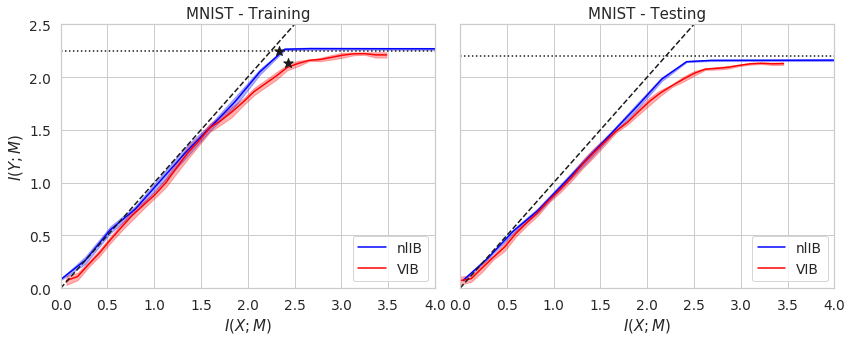

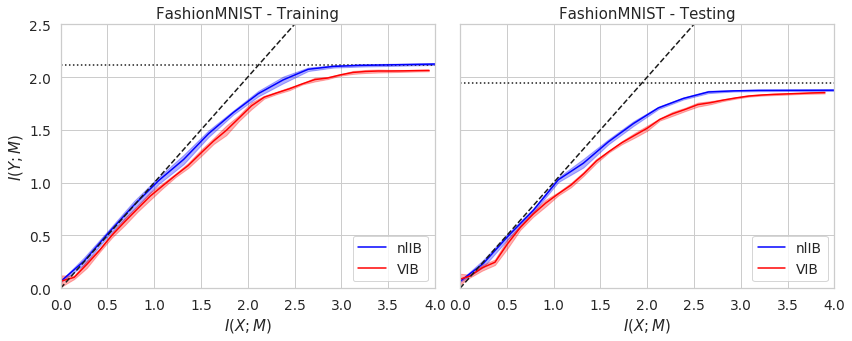

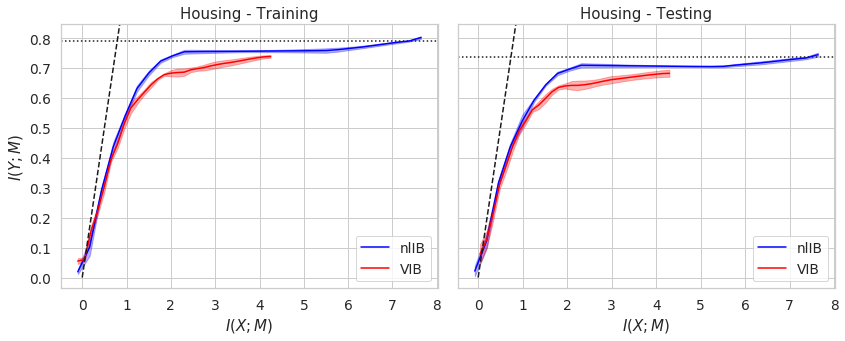

In [164]:
maxruns    = 5
resultsdir = 'savedata200/'
figdir     = 'outputpdf/v1'

if figdir is not None and not os.path.exists(figdir):
    os.makedirs(figdir)
    
    
run_results = {}
baselines   = {}
    
for runtype in [ 'MNIST','FashionMNIST','Housing', ]:
    data = loaddata.load_data(runtype, validation='True')
        
    for cdir in os.listdir(resultsdir):
        
        if not cdir.endswith('10'):
            continue
            
        basedir = os.path.join(resultsdir, cdir, runtype)
        if not os.path.exists(basedir):
            print(basedir, 'doesnt exist')
            continue
        print(basedir)

        tf.reset_default_graph()
        run_results[runtype] = {}
        with tf.Session(config=tfconfig) as sess:
            baselines[runtype] = loadresults(sess, data, basedir,'basemodel', rerun=True, store_batch=True)
            for run in range(maxruns):
                store_batch = run == 0
                res = loadresults(sess, data, basedir, 'run'+str(run), rerun=store_batch, store_batch=store_batch)
                for k, v in res.items():
                    if k not in run_results[runtype]:
                        run_results[runtype][k] = []
                    run_results[runtype][k].append(v)

        for sqmode in ['sq',]:
            axes = plotresults(baselines[runtype], run_results[runtype], methods=['nlIB','VIB'], sqmodes=[sqmode,])
            #plt.suptitle(cdir)#  + ' ' + sqmode)
            if runtype == 'MNIST':
                plt.sca(axes[0])
                plt.scatter(2.4265032933366513, 2.134885 , 100, 'k', marker='*', zorder=5, alpha=1)
                plt.scatter(2.3313439713132595, 2.2476184, 100, 'k', marker='*', zorder=5, alpha=1)
            if True:
                pdfname = '%s/%s-%s-%s.pdf' % (figdir, runtype, cdir, sqmode)
                print('saving %s' % pdfname)
                plt.savefig(pdfname, bbox_inches='tight')


Baseline nan 2.1130736
VIB 2.440166764081738 1.8716173
nlIB 2.503264986099026 2.066685


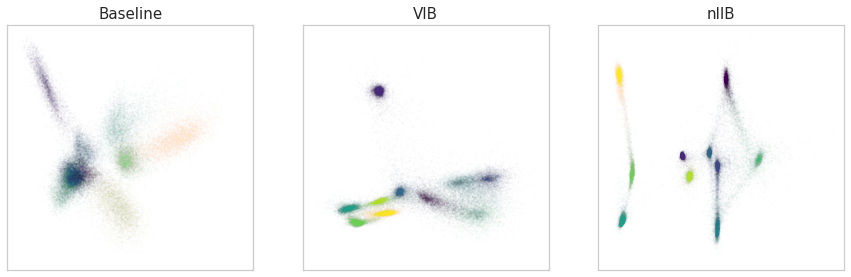

In [199]:
# from sklearn.decomposition import PCA

sns.set_style("whitegrid")
do_pca = True
runtype = 'FashionMNIST'
if False:
    basedir = 'savedata-d2/MNIST/'
    data = loaddata.load_data('MNIST', validation='True')

    tf.reset_default_graph()
    run_results = {}
    with tf.Session(config=tfconfig) as sess:
        baseline = loadresults(sess, data, basedir, 'basemodel', store_batch=True)
        res      = loadresults(sess, data, basedir, 'run0'     , store_batch=True)

    todo = [(baseline[('trn','ce','sq')], 'Baseline'), (res[('trn','VIB','sq')], 'VIB'), (res[('trn','nlIB','sq')], 'nlIB')]
else:
    todo = [(baselines[runtype][('trn','ce','sq')], 'Baseline'), 
            (run_results[runtype][('trn','VIB','sq')][0], 'VIB'), 
            (run_results[runtype][('trn','nlIB','sq')][0], 'nlIB')]
    
plt.figure(figsize=(15,4.5))
for rndx, (r, method) in enumerate(todo):
    plt.subplot(1,3,rndx+1)
    
    alpha = 0.05
    if runtype == 'FashionMNIST':
        alpha = 0.01
    if method =='Baseline':
        ix = 0
    
    else:
        if runtype == 'FashionMNIST':
            ix = np.flatnonzero([l['Ixt_mc'] <= 2.6 for l in r])[0]
        elif runtype == 'MNIST':
        #print(method, [l['Ixt_mc'] for l in r])
            ix = np.argmin([(l['Ixt_mc'] -np.log(10))**2 + (l['Iyt'] - np.log(10))**2 for l in r])
        else:
            raise Exception()
        
    d  = r[ix]
    print(method, d['Ixt_mc'], d['Iyt'])
    mx, y = d['hidden_acts'], d['pred_y']
    #print(d['noisevar'])
    if do_pca:
        pca = PCA(n_components=2, whiten=True)
        pca.fit(mx)
        X_pca = pca.transform(mx)
    else:
        X_pca = mx
    #for i in range(10):
    #    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],  s=1, alpha=.2)
    plt.set_cmap('viridis')

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=100*np.ravel(y).astype('int'),  s=1, alpha=alpha)
    #plt.scatter(X_pca[:, 0], np.ravel(y),  s=1, alpha=.05)
    #print(np.corrcoef(X_pca[:, 1], np.ravel(y)))
    
    plt.xticks([])
    plt.yticks([])
    plt.title(method)

if False:
    plt.savefig('%s/%s-activations-png-v2.png' % (figdir, runtype), bbox_inches='tight', dpi=300)


In [168]:
X_pca.shape

(12574, 2)

In [170]:
y.shape

(12574, 1)

In [186]:
from sklearn.datasets import fetch_california_housing
d=fetch_california_housing()


In [191]:
np.sum(d['target'] >= 5)

992